In [40]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

from sklearn.metrics import r2_score

In [2]:
dpath = '../data/'
df = pd.read_csv(dpath + 'pipeline_output.csv')
target_name = "KWH"

train_data, test_data = train_test_split(df, test_size=0.3)
X_train, y_train = train_data.drop(target_name, axis=1), train_data[target_name]
X_test, y_test = test_data.drop(target_name, axis=1), test_data[target_name]

In [3]:
def scale_datasets(X_train, X_test):
    """
    Standard Scale test and train data
    Z - Score normalization
    """
    sc = StandardScaler()

    X_train_scaled = pd.DataFrame(sc.fit_transform(X_train),
                                columns = X_train.columns)

    X_test_scaled = pd.DataFrame(sc.transform(X_test),
                                columns = X_test.columns)
                                
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = scale_datasets(X_train, X_test)

In [5]:
def scale_target(y_train, y_test):
    """
    Scale target variable for prediction
    """
    sc = StandardScaler()

    y_train_scaled = pd.DataFrame(sc.fit_transform(y_train),
                                columns = y_train.columns)

    y_test_scaled = pd.DataFrame(sc.transform(y_test),
                                columns = y_test.columns)
                                
    return y_train_scaled, y_test_scaled

y_train_scaled, y_test_scaled = scale_datasets(y_train, y_test)

ValueError: Expected 2D array, got 1D array instead:
array=[14313.  7539. 19092. ...  2279.  6229.  6981.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [7]:
dfy_train = pd.DataFrame(y_train)
dfy_test = pd.DataFrame(y_test)

target_scaler = MinMaxScaler()
target_scaler.fit(dfy_train)

y_train_scaled = target_scaler.transform(dfy_train)
y_test_scaled = target_scaler.transform(dfy_test)
# it worked 


In [11]:
print(X_test_scaled.shape)
print(y_test.shape)
print(y_test_scaled.shape)

print(X_train_scaled.shape)
print(y_train.shape)
print(y_train_scaled.shape)

(3625, 485)
(3625,)
(3625, 1)
(8458, 485)
(8458,)
(8458, 1)


In [12]:
hidden_units1 = 160
hidden_units2 = 480
hidden_units3 = 256
learning_rate = 0.01

# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dropout(0.2),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='linear')
  ])
  return model
  
# build the model
model = build_model_using_sequential()

# loss function
msle = MeanSquaredLogarithmicError()
model.compile(
    loss=msle, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[msle])

2022-08-03 10:23:31.665872: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

history = model.fit(X_train.values, y_train.values,
                    epochs=30,
                    verbose=1,
                    validation_data=(X_test.values, y_test.values),
                    batch_size=64,
                    callbacks=[callback]
                    )



2022-08-03 10:23:52.124985: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
133/133 [==============================] - 1s 6ms/step - loss: 1.1393 - mean_squared_logarithmic_error: 1.1329 - val_loss: 0.1372 - val_mean_squared_logarithmic_error: 0.1371
Epoch 2/30
133/133 [==============================] - 1s 4ms/step - loss: 0.1404 - mean_squared_logarithmic_error: 0.1400 - val_loss: 0.1141 - val_mean_squared_logarithmic_error: 0.1141
Epoch 3/30
133/133 [==============================] - 1s 4ms/step - loss: 0.1293 - mean_squared_logarithmic_error: 0.1295 - val_loss: 0.1058 - val_mean_squared_logarithmic_error: 0.1057
Epoch 4/30
133/133 [==============================] - 1s 4ms/step - loss: 0.1179 - mean_squared_logarithmic_error: 0.1177 - val_loss: 0.0998 - val_mean_squared_logarithmic_error: 0.0998
Epoch 5/30
133/133 [==============================] - 1s 5ms/step - loss: 0.1108 - mean_squared_logarithmic_error: 0.1105 - val_loss: 0.0949 - val_mean_squared_logarithmic_error: 0.0950
Epoch 6/30
133/133 [==============================] - 1s 5ms/step - lo

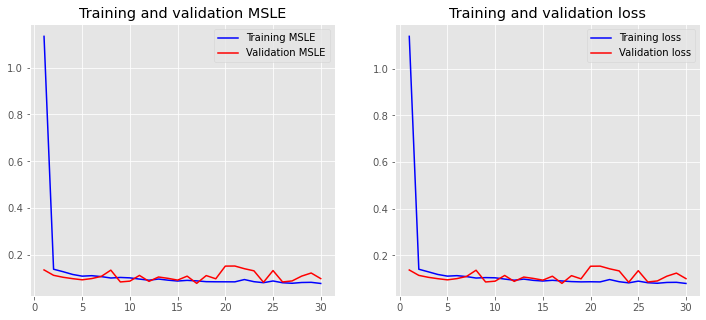

In [14]:
plt.style.use('ggplot')

def plot_history(history):
    msle = history.history['mean_squared_logarithmic_error']
    val_msle = history.history['val_mean_squared_logarithmic_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(msle) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, msle, 'b', label='Training MSLE')
    plt.plot(x, val_msle, 'r', label='Validation MSLE')
    plt.title('Training and validation MSLE')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)

In [42]:
#prediect no scaling
prediction = model.predict(X_test)
print(type(y_test))
print(type(prediction))

pred_frame = pd.DataFrame(y_test.copy())
pred_frame['prediction'] = prediction
pred_frame

r2_score(y_test, prediction)

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>


0.7762177516318842

In [44]:
#prediect w scaling
prediction = model.predict(X_test_scaled)
print(type(y_test_scaled))
print(type(prediction))

pred_frame = pd.DataFrame(y_test_scaled.copy())
pred_frame['prediction'] = prediction
pred_frame

#r2_score(y_test, prediction)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


,0,prediction
0,0.092387,381.869659
1,0.033900,37.785530
2,0.048810,104.506500
3,0.025746,33.449596
4,0.033181,529.927734
...,...,...
3620,0.014504,45.817677
3621,0.050913,76.755653
3622,0.103403,849.047791
3623,0.130540,973.939880


In [82]:
sc.inverse_transform(predictions.reshape(-1,1)).reshape(-1)

ValueError: non-broadcastable output operand with shape (3625,1) doesn't match the broadcast shape (3625,485)

In [ ]:
predictions = scaler.inverse_transform(predictions.reshape(-1,1)).reshape(-1)